# <center>What's in my water? - <br>A long-term study of water quality in Rocky Mountain alpine lakes</center>
### <center>Maeve McCormick, advised by Chuck Rhoades and Tim Fegel. Summer, 2021.<br> Keywords: aquatic chemistry, drought, alpine limnology, water quality, timeseries trends</center>

# Import Packages

In [1]:
import os
import warnings

import folium
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import numpy as np
import pandas as pd

import contextily as ctx
import earthpy as et
import geopandas as gpd
import rasterio as rio
import seaborn as sns

# Import custom functions module
import functions_for_lakechem as flc

# Suppress simple warnings
warnings.simplefilter('ignore')

'''
A note on downloading the data : 
As this is research in its preliminary stages, the data are not yet publicly
available. A working version of the data are shared in the github repository.
The subset of the data represents 15 of the 43 lakes surveyed.

Please additionally note these data have a gap from 2012-2016 due to sampling
difficulties and a lapse in analytic equipment availability.
'''

# Define a variable for the working directory path.
wd_path = os.path.join(et.io.HOME,
                       "earth-analytics",
                       "alpine-lake-chemistry")
# Set the working directory or make the directory if it does not already exist.
if os.path.exists(wd_path):
    os.chdir(wd_path)
    print("The current working directory is", wd_path)
else:
    os.makedirs(wd_path)
    os.chdir(wd_path)
    print("The path does not exist but is being created")

The current working directory is C:\Users\maeve\earth-analytics\alpine-lake-chemistry


### Help on the special functions in functions_for_lakechem (flc)

In [2]:
# help(flc)

## Open Lake Chemistry and Spatial Data

In [3]:
# Create file paths
fig_path = os.path.join('figures')
lakeproj_path = os.path.join('data')
lakechem_path = os.path.join(lakeproj_path,
                             'longterm-lake-chemistry-R2-subset.csv')
lakegeo_path = os.path.join(lakeproj_path,
                            'lakes_geotype.csv')
state_bounds_path = os.path.join(lakeproj_path,
                                 'TIGER2018',
                                 'STATE',
                                 'tl_2018_us_state.shp')

# Open lake chemistry file as a pandas dataframe, indexing by date.
# Clean up some column names and remove trailing whitespace.
lakechem_all = pd.read_csv(lakechem_path,
                           parse_dates=['date'],
                           index_col=['date'],
                           na_values=['NaN']) 

lakechem_all = lakechem_all.rename(columns={'site-rename': 'site_name'})
lakechem_all['site_name'] = lakechem_all['site_name'].str.rstrip()

# Open the lake geology data and join it to the lakechem dataframe.
lakegeo_all = pd.read_csv(lakegeo_path, index_col=['site_name'])
lakechem_all = lakechem_all.join(lakegeo_all, on='site_name')

# Generate a cleaner gdf for plotting from the coordinates in lakechem_all.
lake_coords = flc.pull_coords(source_df=lakechem_all, site_ID='site_name',
                              lat_col='LAT', long_col='LONG', crs='EPSG:4326')

# Open state boundary shapefiles and select only the states in Ecoregion 2 for
# which longterm data exists.
state_bounds = gpd.read_file(state_bounds_path)
states = ['CO']
state_bounds = state_bounds.loc[state_bounds['STUSPS'].isin(states)]

# Optional: take a look!
# lakechem_all.head()
# lake_coords.head()
# state_bounds.head()
# lakegeo_all.head()

The LAT column does not need to be renamed.
The LONG column does not need to be renamed.


## Sort and Filter

In [4]:
# Filter for parameters of interest by dropping unused columns.
lakechem_subset = lakechem_all.drop(['national-forest', 'wilderness-area',
                                     'LAT', 'LONG', 'UTME', 'UTMN', 'ZONE',
                                     'time', 'monitoring-site-name',
                                     'COMMENT', 'rock_descriptor'], axis=1)

# Filter by geology type and group by lake name.
ig_lakes = lakechem_subset.loc[lakechem_subset['broad_type'] == 'igneous']
sed_lakes = lakechem_subset.loc[lakechem_subset['broad_type'] == 'sedimentary']
meta_lakes = lakechem_subset.loc[lakechem_subset['broad_type'] == 'metamorphic']
ig_by_lake = ig_lakes.groupby(['site_name'])
sed_by_lake = sed_lakes.groupby(['site_name'])
meta_by_lake = meta_lakes.groupby(['site_name'])

# Optional : take a look!
# lakechem_subset.head()

In [5]:
# Create dictionaries for custom colormapping and markers in plotting.
lch_site_grp = lakechem_subset.groupby(['site_name'])
lch_geo_grp = lakechem_subset.groupby(['broad_type'])

lakenames = np.concatenate(
    sorted(lch_site_grp['site_name'].unique())).ravel()
geotypes = np.concatenate(
    sorted(lch_geo_grp['broad_type'].unique())).ravel()

colors1 = sns.color_palette("gist_ncar_r", n_colors=len(lakenames))
colors2 = sns.color_palette('gist_earth', n_colors=len(geotypes))

color_dict_lakes = dict(zip(lakenames, colors1))
color_dict_geo = dict(zip(geotypes, colors2))
markers1 = ['s', '^', 'o']

# Prettier plotting with seaborn (set plot theme)
sns.set_context("talk")
sns.set_style("darkgrid", {'axes.facecolor': '#d7d7e0', "font.family": "serif"})

# Plots

### Nutrient Concentration Timeseries Plots

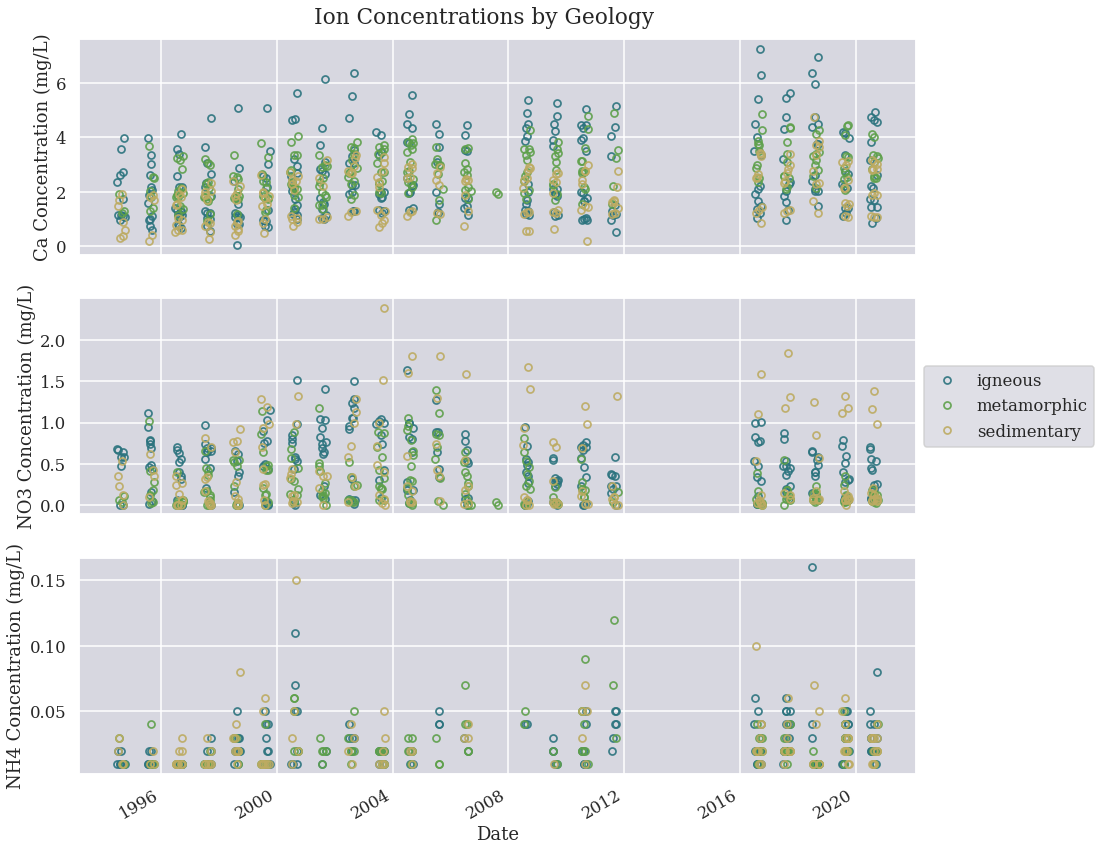

In [20]:
# Figure 1 : A Timeseries of Select Ion Concentrations grouped by Geology.
f1, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
f1.suptitle('Ion Concentrations by Geology', y = 0.91)
params = ['Ca', 'NO3', 'NH4']
axes_flat = axes.ravel()

for ax, aparam in zip(axes_flat, params):
    flc.time_plot(lch_geo_grp, aparam, ax, color_dict_geo)
    ax.set(xlabel='Date',
           ylabel=aparam + ' Concentration (mg/L)')

plt.legend(loc='center left', bbox_to_anchor=(1, 1.7))
plt.savefig(os.path.join('figures', 'ions_by_geo.png'),
            format='png', bbox_inches="tight")
plt.show()

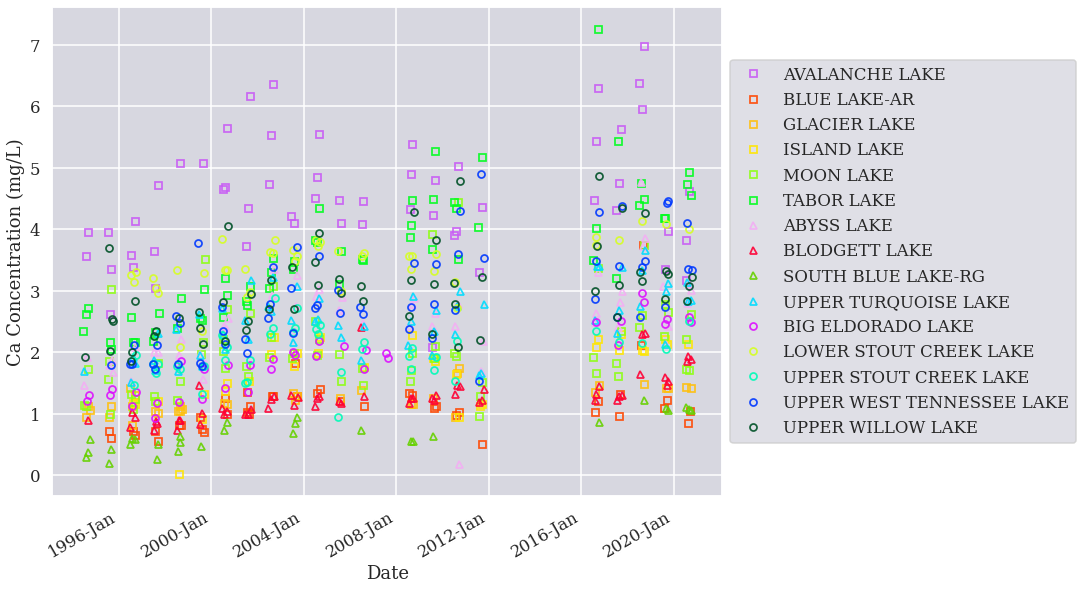

In [7]:
# Figure 2 : Calcium Concentration by Geology [marker] and Lake [color]
# The intent of this figure is to show how messy it is to view all of the data
# together, which is why the subsequent plots are separated by geology type.
f2, ax2 = plt.subplots(figsize=(12, 10))
date_form = DateFormatter('%Y-%b')
ax2.xaxis.set_major_formatter(date_form)

geo_groups = [ig_by_lake, sed_by_lake, meta_by_lake]

for group, marker in zip(geo_groups, markers1):
    flc.time_plot(group, 'Ca', ax2, color_dict_lakes, marker = marker)

ax2.set(xlabel='Date',
       ylabel='Ca Concentration (mg/L)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join('figures', 'chaotic_timeseries.png'),
            format='png', bbox_inches="tight")
plt.show()

In [8]:
# This cell generates ion concentration timeseries plots broken into groups
# based on broad geology type. There are 6 lakes on igneous, 4 on sedimentary,
# and 5 on metamorphic rock. Each point color corresponds to an individual lake.
ions = ['Na', 'NH4', 'K', 'Mg', 'Ca', 'F', 'Cl', 'NO3', 'SO4']
geo_names = ['igneous', 'sedimentary', 'metamorphic']
geo_groups = [ig_by_lake, sed_by_lake, meta_by_lake]
date_form = DateFormatter('%Y-%b')

for geo, name in zip(geo_groups, geo_names):
    for ion in ions:
        fnew, ax = plt.subplots(figsize = (12, 6))
        ax.xaxis.set_major_formatter(date_form)
        flc.time_plot(geo, ion, ax, color_dict_lakes, marker = 'o')
        ax.set(xlabel='Date',
               ylabel=ion + ' Concentration (mg/L)')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        filename = name + ion + '_timeseries.png'
        plt.savefig(os.path.join('figures', filename),
                    format='png', bbox_inches="tight")
        plt.close() # comment out or remove this line to see plots in workflow
print('Done generating figures! Check the folder named figures to see them.')

Done generating figures! Check the folder named figures to see them.


### Water Quality Timeseries Plots

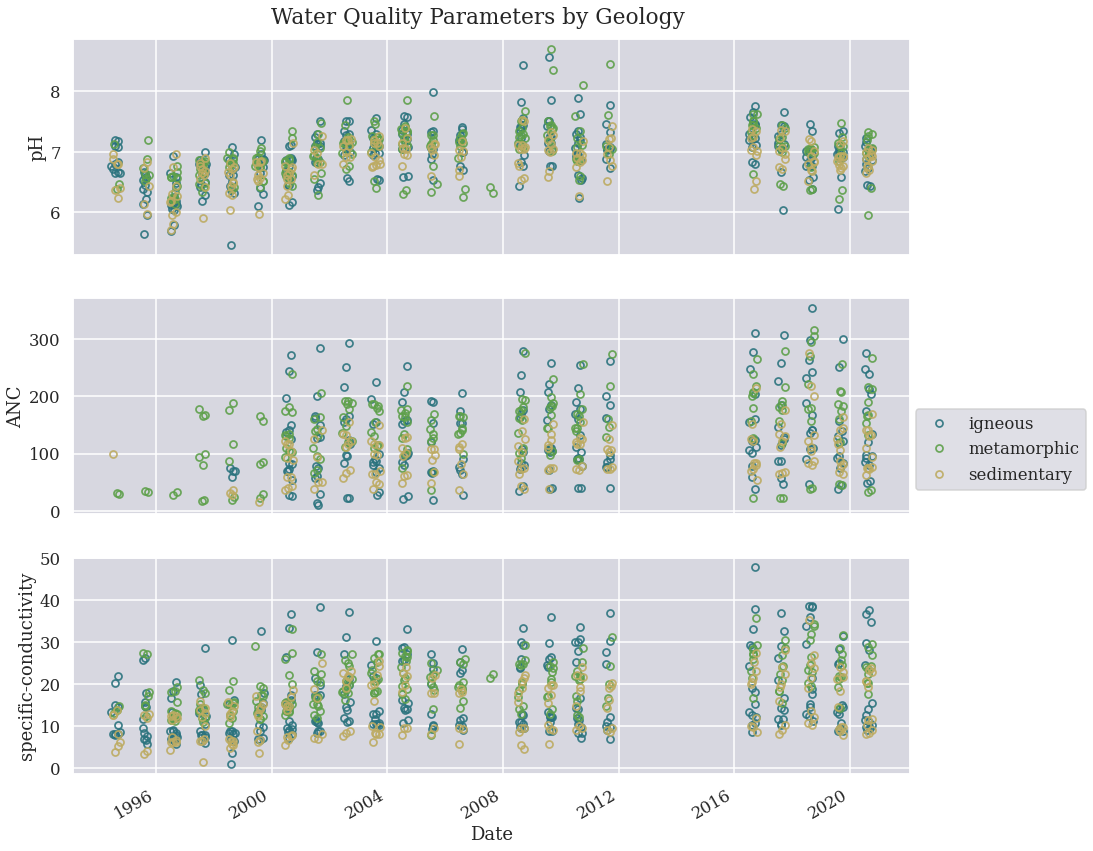

In [9]:
# Figure 3 : A Timeseries of Water Quality Parameters grouped by Geology.
f3, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
f3.suptitle('Water Quality Parameters by Geology', y=0.91)
params = ['pH', 'ANC', 'specific-conductivity']
axes_flat = axes.ravel()

for ax, aparam in zip(axes_flat, params):
    flc.time_plot(lch_geo_grp, aparam, ax, color_dict_geo, marker='o')
    ax.set(xlabel='Date',
           ylabel=aparam)

plt.legend(loc='right', bbox_to_anchor=(1.22, 1.5))
plt.savefig(os.path.join('figures', 'wq_by_geo.png'),
            format='png', bbox_inches="tight")
plt.show()

In [10]:
# Similarly to above, this cell generates several timeseries plots broken into
# groups based on broad geology type. In this case, the variables plotted are
# water quality parameters (pH, Acid Neutralization Capacity [ANC], and 
# Specific Conductivity [SC]).
params = ['pH', 'ANC', 'specific-conductivity']

for geo, name in zip(geo_groups, geo_names):
    for wq in params:
        fnew, ax = plt.subplots(figsize = (12, 6))
        ax.xaxis.set_major_formatter(date_form)
        flc.time_plot(geo, wq, ax, color_dict_lakes, marker = 'o')
        ax.set(xlabel='Date',
               ylabel=wq)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        filename = name + wq + '_timeseries.png'
        plt.savefig(os.path.join('figures', filename),
                    format='png', bbox_inches="tight")
        plt.close() # comment out or remove this line to see plots in workflow
        
print('Done generating figures! Check the folder named figures to see them.')

Done generating figures! Check the folder named figures to see them.


# Map

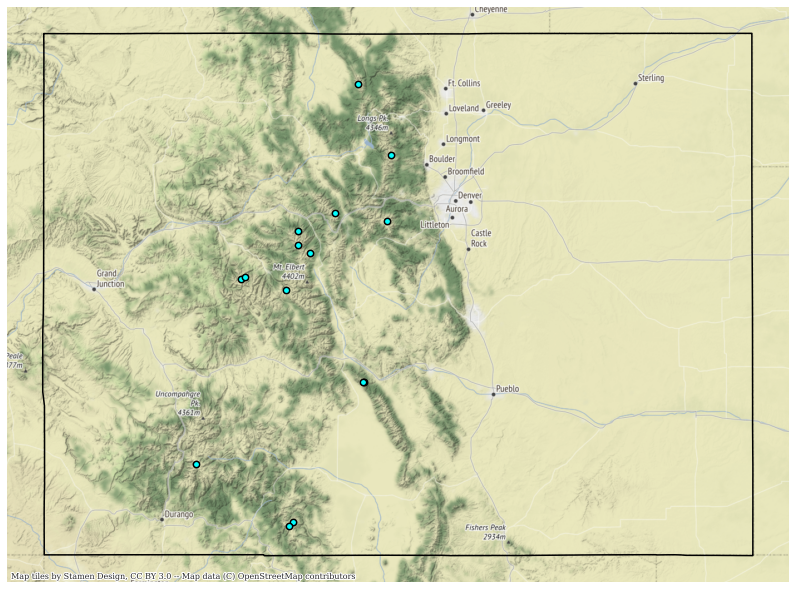

In [11]:
# Convert lake coordinates and state borders to share basemap crs
lake_coords_projected = lake_coords.to_crs(epsg=3857)
states_projected = state_bounds.to_crs(epsg=3857)

# Add a webmap basemap with contextily
fmap, axm = plt.subplots(figsize=(14, 14))
states_projected.plot(ax=axm, color='none', edgecolor='black')
lake_coords_projected.plot(ax=axm,
                           marker='o', markersize=40,
                           color='aqua', edgecolor='black')
ctx.add_basemap(axm, url=ctx.providers.Stamen.Terrain)
axm.set_axis_off()

plt.savefig(os.path.join('figures', 'co_lakes_subset_map.png'),
            format='png', bbox_inches="tight")